In [1]:
from langchain.prompts import PromptTemplate
from langchain_community.llms import Ollama
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional
from langchain_groq import ChatGroq
import pytesseract
from PIL import Image
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import os
import fitz
import pdfplumber
import ollama

In [2]:
def extract_text(images):
    text = ''
    for img in images:
        extracted_text = pytesseract.image_to_string(img)
        text += extracted_text + '\n'
    return {'response': text}

def extract_text_from_pdf(state):
    images = convert_from_path(state.get('file_path'))
    return extract_text(images)
    
def extract_text_from_pdf1(state):
    doc = fitz.open(state.get('file_path'))
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    return extract_text(images)

def extract_text_from_pdf2(state):
    images = []
    with pdfplumber.open(state.get('file_path')) as pdf:
        for page in pdf.pages:
            img = page.to_image()
            images.append(img.original)
    return extract_text(images)




In [3]:
documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])


sample_prompt = """
Your task is to extract the below fields in the same format from the text mentioned after format:
{{
    "fileName": "",
    "orgName": "",
    "orderId": "",
    "ocrBucketName": "",
    "docType": "",
    "bookingDetails": {{
        "carrierBookingNum": "",
        "billOfLadingNum": "",
        "referenceNumber": "",
        "carrierName": "",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "",
        "placeOfDelivery": "",
        "portOfLoad": "",
        "portOfDischarge": "",
        "temperature": {{
            "unit": "",
            "value": ""
        }},
        "humidity": "",
        "gensetRequired": "",
        "travelType": "",
        "containerDetails": {{
            "code": "",
            "quantity": ""
        }},
        "weight": {{
            "unit": "",
            "value": ""
        }},
        "commodityType": "",
        "hazardous": {{
            "hazCode": "",
            "imoClassType": "",
            "packageCount": "",
            "packageType": "",
            "packageGroup": ""
        }},
        "voyageInfo": {{
            "vesselName": "",
            "voyageNumber": "",
            "imoNumber": "",
            "departureEstimated": "",
            "arrivalEstimated": ""
        }}
    }},
    "shipmentDetails": {{
        "shipmentDate": "",
        "containerPickUpDate": "",
        "railCutOffDate": "",
        "portCutOffDate": "",
        "vgmCutoffDate": "",
        "portOpenDate": "",
        "siCutOffDate": "",
        "shipOnBoardDate": "",
        "vent": ""
    }},
    "containers": [{{
        "containerId": "",
        "type": ""
    }}, {{
        "containerId": "",
        "type": ""
    }}]
}}
    
Text for information extraction:

{text}

Make sure to format the result in the specified format.
"""

# Now `sample_prompt` contains the formatted string with the text from `text_pdf2image`
print(sample_prompt)



Your task is to extract the below fields in the same format from the text mentioned after format:
{{
    "fileName": "",
    "orgName": "",
    "orderId": "",
    "ocrBucketName": "",
    "docType": "",
    "bookingDetails": {{
        "carrierBookingNum": "",
        "billOfLadingNum": "",
        "referenceNumber": "",
        "carrierName": "",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "",
        "placeOfDelivery": "",
        "portOfLoad": "",
        "portOfDischarge": "",
        "temperature": {{
            "unit": "",
            "value": ""
        }},
        "humidity": "",
        "gensetRequired": "",
        "travelType": "",
        "containerDetails": {{
            "code": "",
            "quantity": ""
        }},
        "weight": {{
            "unit": "",
            "value": ""
        }},
        "commodityType": "",
        "hazardous": {{
            "hazCode": "",
            "imoClassType": "",
        

In [4]:
"""prompt = PromptTemplate(template=sample_prompt)
llm = Ollama(model="llama3")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", extract_text_from_pdf)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'])"""

'prompt = PromptTemplate(template=sample_prompt)\nllm = Ollama(model="llama3")\nclass GraphState(TypedDict):\n    file_path: Optional[str]\n    response: Optional[str]\nwf = StateGraph(GraphState)\ndef process_text(state):\n    current_response = state.get(\'response\')\n    chain = prompt | llm \n    result = chain.invoke({"text": current_response})\n    return {\'response\': result}\n\nwf.add_node("node_1", extract_text_from_pdf)\nwf.add_node("node_2", process_text)\nwf.set_entry_point("node_1")\nwf.add_edge("node_1", "node_2")\nwf.set_finish_point("node_2")\n\napp = wf.compile()\n\n\n\ndocuments_folder = \'documents\'  # Change this to your documents folder path\ndocument_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]\ndocument_files = [\'COSCO.pdf\']\ndocument_path = os.path.join(documents_folder, document_files[0])\n\noutput = app.invoke({\'file_path\': document_path})\nprint(output[\'response\'])'

In [5]:
prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", extract_text_from_pdf)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "",
    "orgName": "COSCO SHIPPING Lines (North America) Inc.",
    "orderId": "6343267510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "6343267510",
        "billOfLadingNum": "",
        "referenceNumber": "LAN22039",
        "carrierName": "COSCO SHIPPING Lines (North America) Inc.",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "Long Beach,Los Angeles, California, United States",
        "placeOfDelivery": "Hong Kong,Hong Kong",
        "portOfLoad": "Long Beach",
        "portOfDischarge": "Hong Kong",
        "temperature": {
            "unit": "F",
            "value": "68"
        },
        "humidity": "",
        "gensetRequired": "Y",
        "travelType": "",
        "containerDetails": {
            "code": "40' Hi-Cube Refrigerated Container",
            "quantity"

In [6]:
prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", extract_text_from_pdf1)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "FWK2 2022080600491 400.54",
    "orgName": "COSCO SHIPPING Lines (North Amerca ne. Los Anges",
    "orderId": "6242287510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "6242287510",
        "billOfLadingNum": "",
        "referenceNumber": "LAVZZ0S9",
        "carrierName": "COSCO SHIPPING Lines (North Amerca ne. Los Anges",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "",
        "placeOfDelivery": "Hong Kong Cosco t Terminal (HongKong)",
        "portOfLoad": "",
        "portOfDischarge": "Hong Kong Cosco t Terminal (HongKong)",
        "temperature": {
            "unit": "",
            "value": ""
        },
        "humidity": "",
        "gensetRequired": "GENSET: Yes",
        "travelType": "",
        "containerDetails": {
            "code": "8X 4'H.Cbe RtigerstedCotnn

In [7]:
prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", extract_text_from_pdf2)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "",
    "orgName": "COSCO SHIPPING Lines",
    "orderId": "6343267510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "AN22080",
        "billOfLadingNum": "",
        "referenceNumber": "CO8075357830",
        "carrierName": "COSCO SHIPPING Lines",
        "originServiceMode": "Sea",
        "destinationServiceMode": "",
        "placeOfOrigin": "Long Beach, Lang Geach coe Terminal LLC",
        "placeOfDelivery": "Hong Kong",
        "portOfLoad": "Long Beach, Lang Geach coe Terminal LLC",
        "portOfDischarge": "Hong Kong",
        "temperature": {
            "unit": "",
            "value": ""
        },
        "humidity": "",
        "gensetRequired": "Y",
        "travelType": "",
        "containerDetails": {
            "code": "6X40",
            "quantity": "1"
        },
        "weight": {
            "unit": "",
 

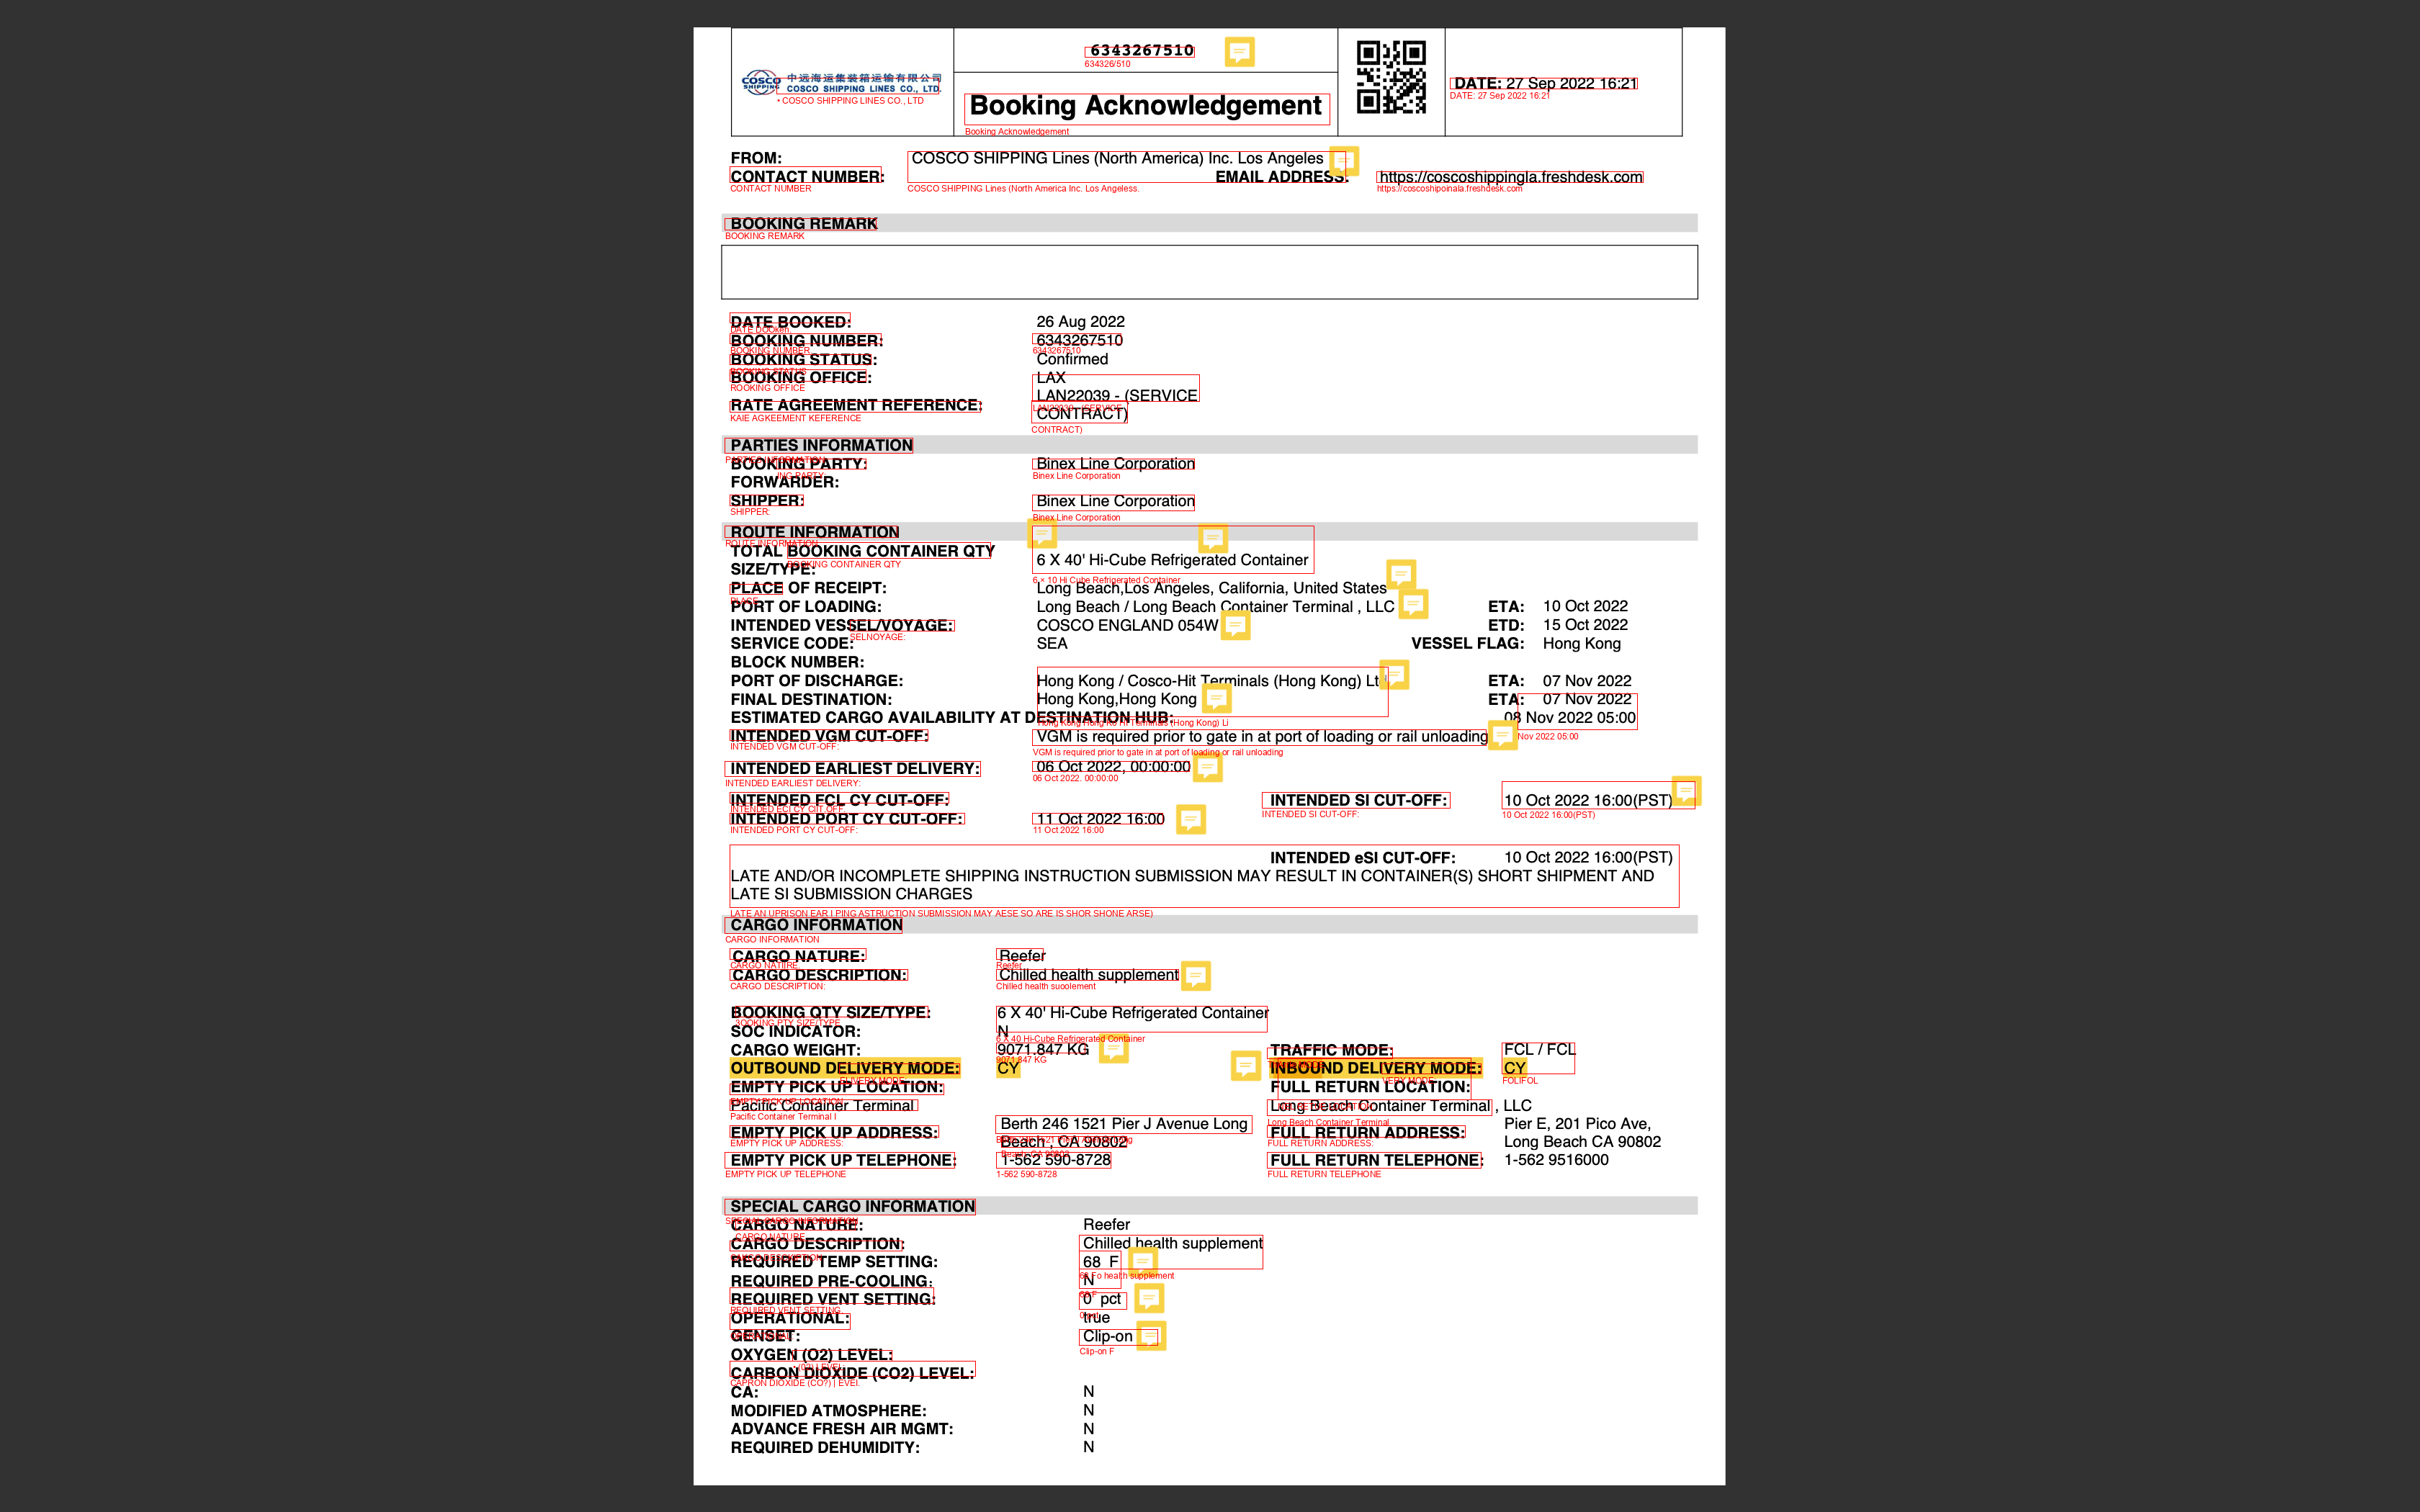

In [8]:
from ocrmac import ocrmac
ocrmac.OCR('Screenshot 2024-07-02 at 11.49.24 PM.png',language_preference=['en-US']).annotate_PIL()

In [9]:
from ocrmac import ocrmac
print(ocrmac.OCR('Screenshot 2024-07-02 at 11.49.24 PM.png',language_preference=['en-US'],recognition_level='accurate').recognize())

[('• COSCO SHIPPING LINES CO., LTD', 1.0, [0.3211206910125586, 0.9377142857673713, 0.06681033543178005, 0.010561575753348262]), ('634326/510', 1.0, [0.44827586145030085, 0.9620689659494485, 0.045258617401123025, 0.006896550859723738]), ('Booking Acknowledgement', 1.0, [0.3987069000056725, 0.9171428575606583, 0.15086206708635602, 0.020788176400320935]), ('COSCO SHIPPING Lines (North America Inc. Los Angeless.', 1.0, [0.3750000156287875, 0.8793103448895956, 0.1810344696044922, 0.02068965475899831]), ('DATE: 27 Sep 2022 16:21', 1.0, [0.5991379310206821, 0.9411428570490818, 0.07758620670863559, 0.0071330051422119345]), ('https://coscoshipoinala.freshdesk.com', 0.30000001192092896, [0.5689655197644463, 0.8793103447215979, 0.10991378784179684, 0.006896551949637231]), ('CONTACT NUMBER', 1.0, [0.3017241437808179, 0.8793103453758322, 0.06249999455043248, 0.010403940473284079]), ('BOOKING REMARK', 1.0, [0.29956896540948275, 0.8479999999555158, 0.0625, 0.007428571428571451]), ('DATE DOOken.', 0.5

In [10]:
import objc
from Cocoa import NSURL
from Quartz import CIImage
from Vision import VNImageRequestHandler, VNRecognizeTextRequest, VNRecognizedTextObservation

def recognize_text_in_image(state):
    image_path=state.get("file_path")
    # Convert image file path to NSURL
    image_url = NSURL.fileURLWithPath_(image_path)
    
    # Create a CIImage from the image file
    ci_image = CIImage.imageWithContentsOfURL_(image_url)
    
    if ci_image is None:
        print(f"Failed to load image from {image_path}")
        return None
    
    # Create a text recognition request
    recognized_texts = []

    def handle_text_recognition_request(request, error):
        if error is not None:
            print(f"Error: {error.localizedDescription()}")
            return
        for observation in request.results():
            if isinstance(observation, VNRecognizedTextObservation):
                top_candidate = observation.topCandidates_(1)[0]
                recognized_texts.append(top_candidate.string())
    
    request = VNRecognizeTextRequest.alloc().initWithCompletionHandler_(handle_text_recognition_request)
    
    # Create an image request handler
    handler = VNImageRequestHandler.alloc().initWithCIImage_options_(ci_image, None)
    
    # Perform the request
    success, error = handler.performRequests_error_([request], None)
    
    if not success:
        print(f"Failed to perform text recognition request: {error.localizedDescription()}")
        return None

    # Join all recognized text parts into a single string
    k= "\n".join(recognized_texts)
    return {"response":k}



In [11]:
prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", recognize_text_in_image)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': 'Screenshot 2024-07-02 at 11.49.24 PM.png'})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "",
    "orgName": "COSCO SHIPPING LINES CO., LTD",
    "orderId": "634326/510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "6343267510",
        "billOfLadingNum": "",
        "referenceNumber": "LAN22039",
        "carrierName": "COSCO SHIPPING Lines (North America Inc.",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "Hong Kong",
        "placeOfDelivery": "Long Beach",
        "portOfLoad": "Hong Kong Hong Ko HI Terminals (Hong Kong) Li",
        "portOfDischarge": "Long Beach Container Terminal",
        "temperature": {
            "unit": "F",
            "value": "68"
        },
        "humidity": "0 pct",
        "gensetRequired": "",
        "travelType": "",
        "containerDetails": {
            "code": "6 × 10 Hi Cube Refrigerated Container",
            "quantity"

In [12]:

def automate_text(state):
    with open(state.get("file_path")) as temp:
        text=temp.read()
    return {"response":text}

prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", automate_text)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'OUT'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.txt']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "",
    "orgName": "COSCO SHIPPING Lines (North America) Inc.",
    "orderId": "6343267510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "6343267510",
        "billOfLadingNum": "",
        "referenceNumber": "LAN22039",
        "carrierName": "COSCO SHIPPING Lines (North America) Inc.",
        "originServiceMode": "",
        "destinationServiceMode": "",
        "placeOfOrigin": "Long Beach,Los Angeles, California, United States",
        "placeOfDelivery": "Hong Kong,Hong Kong",
        "portOfLoad": "Long Beach / Long Beach Container Terminal , LLC",
        "portOfDischarge": "Hong Kong / Cosco-Hit Terminals (Hong Kong) Ltd",
        "temperature": {
            "unit": "F",
            "value": "68"
        },
        "humidity": "",
        "gensetRequired": "true",
        "travelType": "",
        "containerDetails": {
 

In [13]:
document_path

'OUT/COSCO.txt'

In [14]:
def extract_text_from_pdf_direct(state):
    pdf_path=state.get("file_path")
    all_text = []

    # Open the PDF file
    with pdfplumber.open(pdf_path) as pdf:
        # Loop through each page
        for page in pdf.pages:
            # Extract text from the current page
            page_text = page.extract_text()
            if page_text:
                all_text.append(page_text)

    # Join all text from all pages
    complete_text = "\n".join(all_text)
    return {'response':complete_text}

In [15]:
prompt = PromptTemplate(template=sample_prompt)
llm = ChatGroq(model="llama3-70b-8192",groq_api_key="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")
class GraphState(TypedDict):
    file_path: Optional[str]
    response: Optional[str]
wf = StateGraph(GraphState)
def process_text(state):
    current_response = state.get('response')
    chain = prompt | llm 
    result = chain.invoke({"text": current_response})
    return {'response': result}

wf.add_node("node_1", extract_text_from_pdf_direct)
wf.add_node("node_2", process_text)
wf.set_entry_point("node_1")
wf.add_edge("node_1", "node_2")
wf.set_finish_point("node_2")

app = wf.compile()



documents_folder = 'documents'  # Change this to your documents folder path
document_files = [f for f in os.listdir(documents_folder) if os.path.isfile(os.path.join(documents_folder, f))]
document_files = ['COSCO.pdf']
document_path = os.path.join(documents_folder, document_files[0])

output = app.invoke({'file_path': document_path})
print(output['response'].content)

Here is the extracted information in the specified format:

```
{
    "fileName": "",
    "orgName": "COSCO SHIPPING Lines (North America) Inc.",
    "orderId": "6343267510",
    "ocrBucketName": "",
    "docType": "Booking Acknowledgement",
    "bookingDetails": {
        "carrierBookingNum": "6343267510",
        "billOfLadingNum": "",
        "referenceNumber": "LAN22039",
        "carrierName": "COSCO SHIPPING Lines (North America) Inc.",
        "originServiceMode": "FCL",
        "destinationServiceMode": "FCL",
        "placeOfOrigin": "Long Beach, Los Angeles, California, United States",
        "placeOfDelivery": "Hong Kong, Hong Kong",
        "portOfLoad": "Long Beach / Long Beach Container Terminal, LLC",
        "portOfDischarge": "Hong Kong / Cosco-Hit Terminals (Hong Kong) Ltd",
        "temperature": {
            "unit": "F",
            "value": "68"
        },
        "humidity": "",
        "gensetRequired": "Clip-on",
        "travelType": "",
        "containerDet